In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv(r"D:\EPL\topassist.csv")

# Drop unnecessary columns
drop_cols = [
     "Rank", "Club",
    "Crosses_Completed", "Assists_per_90",
    "xA_per_90", "Key_Passes_per_90"
]
df.drop(columns=drop_cols, inplace=True)

In [29]:
# Check nulls
print("Before filling:\n", df.isnull().sum())

# Fill numeric columns with mean
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Fill categorical columns with 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

# Check again
print("\nAfter filling:\n", df.isnull().sum())

Before filling:
 Season                     0
Age                        0
Position                   0
Minutes_Played             0
Assists_prev_season      108
Goals_prev_season         88
Assists                    0
Key_Passes                 0
Expected_Assists_(xA)      0
Dribbles_Completed         0
Shots_Assisted             0
Set_Piece_Involvement      0
Club_Total_Goals           0
Club_League_Rank           0
Big6_Club_Feature          0
Club_Attack_Share          0
Club_xG                    0
dtype: int64

After filling:
 Season                   0
Age                      0
Position                 0
Minutes_Played           0
Assists_prev_season      0
Goals_prev_season        0
Assists                  0
Key_Passes               0
Expected_Assists_(xA)    0
Dribbles_Completed       0
Shots_Assisted           0
Set_Piece_Involvement    0
Club_Total_Goals         0
Club_League_Rank         0
Big6_Club_Feature        0
Club_Attack_Share        0
Club_xG                  0
d

In [30]:
# Check duplicates
print("Duplicates:", df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)

Duplicates: 0


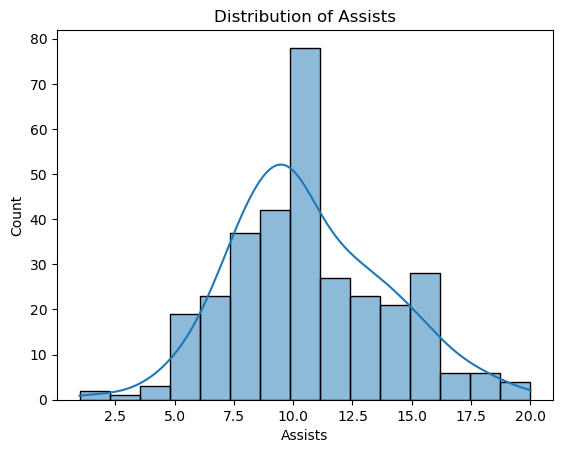

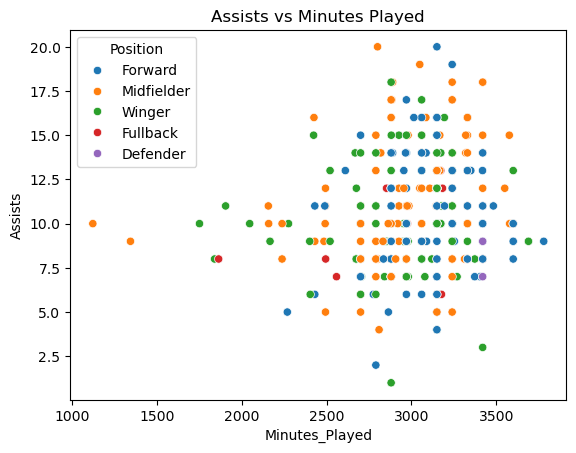

In [31]:
# Distribution of Assists
sns.histplot(df["Assists"], bins=15, kde=True)
plt.title("Distribution of Assists")
plt.show()

# Assists vs Minutes Played
sns.scatterplot(x="Minutes_Played", y="Assists", hue="Position", data=df)
plt.title("Assists vs Minutes Played")
plt.show()

In [32]:
# Example: Detect outliers in 'Assists'
Q1 = df["Assists"].quantile(0.25)
Q3 = df["Assists"].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df["Assists"] < (Q1 - 1.5 * IQR)) | (df["Assists"] > (Q3 + 1.5 * IQR))]
print("Outliers in Assists:", outliers.shape[0])

Outliers in Assists: 0


In [33]:
# Feature Engineering
df["Assists_per_90"] = df["Assists"] / (df["Minutes_Played"] / 90)
df["Goals_per_90"] = df["Goals_prev_season"] / (df["Minutes_Played"] / 90)
df["Contribution_Ratio"] = (df["Assists"] + df["Goals_prev_season"]) / df["Club_Total_Goals"]
df["Dribbles_per_90"] = df["Dribbles_Completed"] / (df["Minutes_Played"] / 90)
df["Shots_Assisted_per_90"] = df["Shots_Assisted"] / (df["Minutes_Played"] / 90)


In [34]:
from sklearn.preprocessing import LabelEncoder

label_cols = ["Position", "Set_Piece_Involvement", "Big6_Club_Feature"]

le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])
print(df.head())

    Season  Age  Position  Minutes_Played  Assists_prev_season  \
0  2023-24   28         1            3350                 15.0   
1  2023-24   22         3            2985                  3.0   
2  2023-24   23         4            2954                  2.0   
3  2023-24   32         3            1121                 16.0   
4  2023-24   33         3            3241                  8.0   

   Goals_prev_season  Assists  Key_Passes  Expected_Assists_(xA)  \
0               14.0       13          55                    6.5   
1                3.0       11          46                    6.2   
2               11.0       10          48                    6.1   
3                7.0       10          38                    5.9   
4                9.0       10          58                    7.2   

   Dribbles_Completed  ...  Club_Total_Goals  Club_League_Rank  \
0                  53  ...                76                 4   
1                  62  ...                77                 6

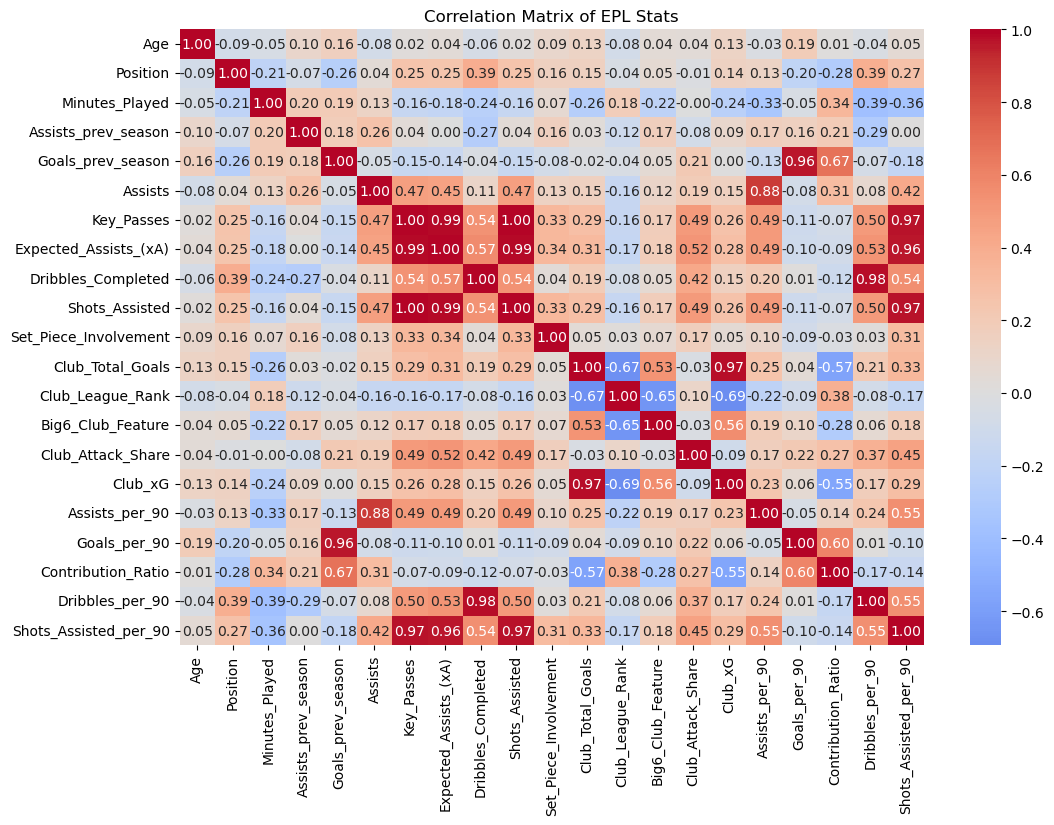

In [11]:


# Compute correlation matrix
corr = df.corr()

# Plot heatmap with values in the grid
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of EPL Stats")
plt.show()


In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define base model
model = RandomForestRegressor(random_state=42)

# Define parameter distribution for random search
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(10, 101, 10)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=50, cv=3, verbose=2, random_state=42,
                                   n_jobs=-1, scoring='r2')

# Fit on train data
random_search.fit(X_train, y_train)

# Best params
print("Best parameters found:", random_search.best_params_)

# Best model
best_rf_model = random_search.best_estimator_

# Predictions and evaluation
y_pred = best_rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found: {'n_estimators': np.int64(1000), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(2), 'max_features': None, 'max_depth': None}
Mean Squared Error: 0.40219101534485235
Root Mean Squared Error: 0.6341853162482181
R² Score: 0.9676223585131188


In [38]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Filter dataset for relevant seasons (e.g., 1992 to 2024)
filtered_df = df[(df['Season'].str.slice(0,4).astype(int) >= 1992) & (df['Season'].str.slice(0,4).astype(int) <= 2024)].copy()

# Fill or handle any missing values in your relevant columns first (optional, depends on your data)
filtered_df.fillna(0, inplace=True)

# Feature engineering: create per 90 and ratio features
filtered_df["Assists_per_90"] = filtered_df["Assists"] / (filtered_df["Minutes_Played"] / 90).replace(0, np.nan)
filtered_df["Goals_per_90"] = filtered_df["Goals_prev_season"] / (filtered_df["Minutes_Played"] / 90).replace(0, np.nan)
filtered_df["Contribution_Ratio"] = (filtered_df["Assists"] + filtered_df["Goals_prev_season"]) / filtered_df["Club_Total_Goals"].replace(0, np.nan)
filtered_df["Dribbles_per_90"] = filtered_df["Dribbles_Completed"] / (filtered_df["Minutes_Played"] / 90).replace(0, np.nan)
filtered_df["Shots_Assisted_per_90"] = filtered_df["Shots_Assisted"] / (filtered_df["Minutes_Played"] / 90).replace(0, np.nan)

# Fill all NaN values generated from division by 0 with 0
filtered_df.fillna(0, inplace=True)

# Fit LabelEncoders on your original full dataset for categorical columns:
Position_encoder = LabelEncoder().fit(df['Position'])
SetPiece_encoder = LabelEncoder().fit(df['Set_Piece_Involvement'])
Big6_encoder = LabelEncoder().fit(df['Big6_Club_Feature'])

# Transform categorical columns in filtered data using fitted encoders
filtered_df['Position'] = Position_encoder.transform(filtered_df['Position'])
filtered_df['Set_Piece_Involvement'] = SetPiece_encoder.transform(filtered_df['Set_Piece_Involvement'])
filtered_df['Big6_Club_Feature'] = Big6_encoder.transform(filtered_df['Big6_Club_Feature'])

# Define feature list exactly as during training
feature_cols = [
    'Age', 'Position', 'Minutes_Played', 'Assists_prev_season', 'Goals_prev_season', 'Key_Passes',
    'Expected_Assists_(xA)', 'Dribbles_Completed', 'Shots_Assisted', 'Set_Piece_Involvement',
    'Club_Total_Goals', 'Club_League_Rank', 'Big6_Club_Feature', 'Club_Attack_Share', 'Club_xG',
    'Assists_per_90', 'Goals_per_90', 'Contribution_Ratio', 'Dribbles_per_90', 'Shots_Assisted_per_90'
]

X_filtered = filtered_df[feature_cols]

# Predict assists using your trained model
filtered_df['Predicted_Assists'] = best_rf_model.predict(X_filtered)

# Group predicted assists by player and sort descending
top_players = filtered_df.groupby('Player')['Predicted_Assists'].sum().sort_values(ascending=False)

print("Top assist players from model prediction (1992-2024):")
print(top_players)


Top assist players from model prediction (1992-2024):
Player
Wayne Rooney             163.199558
Steven Gerrard           153.491291
Frank Lampard            133.447717
Ryan Giggs               131.685251
Kevin De Bruyne          117.073928
                            ...    
Erling Haaland             6.223092
Matt Doherty               6.075054
Michael Owen               6.037186
Martin Ødegaard            5.824220
Dominic Calvert-Lewin      5.140457
Name: Predicted_Assists, Length: 136, dtype: float64
